---
<img src = '../../../logo_dh_grupo3.png'>

# <h1><left><ins>Entrenamiento y Evaluación: Regresión Logística</ins></left></h1>

## Importación de librerías y bases de datos

In [1]:
# Importamos las librerias relevantes

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, \
f1_score, roc_curve, auc, classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importamos las bases de datos

data_0 = pd.read_csv("base_entrenamiento.csv")

In [3]:
# Cantidad de filas y columnas

data_0.shape

(30360, 22)

La base de datos tiene 30,360 observaciones de 22 columnas.

In [4]:
# Nombre y tipo de columnas, ademas de cantidad de filas no nulas

data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30360 entries, 0 to 30359
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   housing               30360 non-null  int64  
 1   loan                  30360 non-null  int64  
 2   contact               30360 non-null  int64  
 3   campaign              30360 non-null  int64  
 4   emp.var.rate          30360 non-null  float64
 5   cons.price.idx        30360 non-null  float64
 6   cons.conf.idx         30360 non-null  float64
 7   euribor3m             30360 non-null  float64
 8   nr.employed           30360 non-null  float64
 9   y                     30360 non-null  int64  
 10  married               30360 non-null  int64  
 11  month_cat             30360 non-null  int64  
 12  age_cat_(34.0, 44.0]  30360 non-null  int64  
 13  age_cat_(44.0, 69.0]  30360 non-null  int64  
 14  job_cat_1             30360 non-null  int64  
 15  job_cat_2          

## Conjuntos de Entrenamiento y Testeo

In [5]:
# Definimos la matriz de features, X, y el vector de la target, y

X = data_0.drop('y', axis = 1)

y = data_0['y']

In [6]:
# Separamos las unidades observadas en unidades para entrenamiento y unidades para testeo

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    test_size = 0.30,
                                                    stratify = y)

In [7]:
# Estandarizamos las features continuas del conjunto de entrenamiento y de testeo

from sklearn.preprocessing import StandardScaler

sd = StandardScaler()

variables_continuas = ['campaign', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
                       'nr.employed']

X_train[variables_continuas] = sd.fit_transform(X_train[variables_continuas])

In [8]:
X_test[variables_continuas] = sd.transform(X_test[variables_continuas])

In [9]:
# Observamos distribucion de la variable target

print(y.value_counts(normalize = True))

print(y_train.value_counts(normalize = True))

print(y_test.value_counts(normalize = True))

0    0.945487
1    0.054513
Name: y, dtype: float64
0    0.945464
1    0.054536
Name: y, dtype: float64
0    0.945542
1    0.054458
Name: y, dtype: float64


Vemos que las clases de la variable target estan desbalanceadas. Procedemos a aplicar oversampling.

In [10]:
# Clases desbalanceadas: aplicamos oversampling sobre conjunto de entrenamiento

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy = 'minority')

X_train_os, y_train_os = ros.fit_sample(X_train, y_train)

In [71]:
y_test.shape

(9108,)

## Modelo Logístico: Hiperparámetros default

In [11]:
# Entranamiento del modelo logistico: hiperparametros default

from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()

model_lr.fit(X_train_os, y_train_os)


LogisticRegression()

In [12]:
# Veamos los hiperparametros del modelo logistico y sus valores default

lr_dft_params = model_lr.get_params()
lr_dft_params

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

En https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html se puede ver una descripción de los mismos. Continuamos con las predicciones y la evaluación del modelo.

In [13]:
# Prediccion de la target usando el modelo logistico con hiperparametros defaults

y_pred_lr_dft = model_lr.predict(X_test)

y_pred_proba_lr_dft = model_lr.predict_proba(X_test)


In [14]:
# Definimos funciones auxiliares que nos haran mas eficientes los ejercicios posteriores

def evaluacion(target_test, target_pred):
    '''Vamos a definir una funcion que nos trae una lista de scores de evaluacion de modelos'''
    
    scores = []
    
    # 0: Matriz de confusion
    confmat = confusion_matrix(target_test, target_pred)
    TN = confmat[0, 0] #True Negatives
    FP = confmat[0, 1] #False Positives
    FN = confmat[1, 0] #False Negatives
    TP = confmat[1, 1] #True Positives
    scores.append(confmat)
    
    # 1: Accuracy Score
    accuracy = accuracy_score(target_test, target_pred)
    scores.append(accuracy)

    # 2: Error de clasificacion
    errclf = 1 - accuracy
    scores.append(errclf)

    # 3: Recall
    recall = recall_score(target_test, target_pred)
    scores.append(recall)

    # 4: Especificidad
    specificity = TN / (TN + FP)
    scores.append(specificity)

    # 5: False Positive Rate
    fpr = 1 - specificity
    scores.append(fpr)

    # 6: Precision
    precision = precision_score(target_test, target_pred)
    scores.append(precision)
    
    # 7: F1 Score
    f1score = f1_score(target_test, target_pred)
    scores.append(f1score)
    
    '''Output de funcion'''
    return scores

def reporte(modelo_name, scores):
    '''Esta funcion nos devuelve un reporte de los scores del modelo indicado'''
    
    print(f'La matriz de confusión del modelo logístico {modelo_name} es: \n{scores[0]}\n')
    print(f'El accuracy score del modelo logístico {modelo_name} es: {scores[1].round(3)}\n')
    print(f'El error de clasificación del modelo logístico {modelo_name} es: {scores[2].round(2)}\n')
    print(f'El recall score del modelo logístico {modelo_name} es: {scores[3].round(3)}\n')
    print(f'La especificidad del modelo logístico {modelo_name} es: {scores[4].round(3)}\n')
    print(f'El false positive rate del modelo logístico {modelo_name} es: {scores[5].round(2)}\n')
    print(f'La precisión del modelo logístico {modelo_name} es: {scores[6].round(3)}\n')
    print(f'El f1 score del modelo logístico {modelo_name} es: {scores[7].round(3)}')

In [15]:
# Evaluacion del modelo logistico con hiperparametros defaults

scores_dft = evaluacion(y_test, y_pred_lr_dft)

# Mostramos el conjunto de medidas de evaluacion

reporte('default', scores_dft)

La matriz de confusión del modelo logístico default es: 
[[6553 2059]
 [ 110  386]]

El accuracy score del modelo logístico default es: 0.762

El error de clasificación del modelo logístico default es: 0.24

El recall score del modelo logístico default es: 0.778

La especificidad del modelo logístico default es: 0.761

El false positive rate del modelo logístico default es: 0.24

La precisión del modelo logístico default es: 0.158

El f1 score del modelo logístico default es: 0.262


## Modelo Logístico: Hiperparámetros óptimos

Del conjunto de hiperparámetros del modelo logístico consideraremos un subconjunto para realizar la búsqueda de valores óptimos, definido a partir de la relevancia de los mismos de acuerdo al problema que enfrentamos: la predicción de una target binaria.
Así, el subconjunto de hiperparámetros que usaremos del modelo logístico está integrado por:
- C: Inversa de la fuerza de regularización.
- fit_intercept: Especifica si se debe agregar una constante (también conocida como sesgo o intersección) a la función de decisión.
- max_iter: Número máximo de iteraciones que se toman para que los solucionadores converjan.
- penalty: Especifica la norma de la pena.
- solver: Algoritmo a utilizar en el problema de optimización.

### Definición de los conjuntos de hiperparámetros

Si bien *C*, *fit_intercept* y *max_inter* pueden combinarse entre sí y con el resto de cualquier manera, no es tal el caso para *penalty* y *solver*. Las combinaciones posibles y no posibles de éstos dos últimos se pueden ver en la tabla a continuación:

<img src = '../../../desafio_final/logistic_hiperparam_table.png'>

La fuente de la tabla es la Guía del Usuario para el modelo logístico, en la cual se presentan las distintas especificaciones del modelo de acuerdo a la penalización elegida y explica el rol de los distintos valores de los hiperparámetros. La misma se puede consultar en https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

A partir esto, vamos a definir tres diccionarios que se diferenciarán entre sí de acuerdo a las combinaciones probadas de *penalty* y *solver*, dejando fijos los rangos de valores probados para *C*, *fit_intercept* y *max_iter*.

El primer diccionario considera que el *solver saga* es el único que se puede combinar con todas las alternativas de *penalty*:

In [16]:
from scipy.stats import loguniform

lr_opt_params_1 = {'C':loguniform.rvs(1e-5, 100, size = 10), 'fit_intercept':[False, True], 'max_iter':[100, 150, 200], 
                   'penalty':['none', 'l1', 'l2', 'elasticnet'], 
                   'solver':['saga']}

El segundo diccionario considera que tanto *newton-cg*, *lbfgs*, *sag* como *saga* se pueden combinar al mismo tiempo con las penalizaciones *none* y *l2*:

In [17]:
lr_opt_params_2 = {'C':loguniform.rvs(1e-5, 100, size = 10), 'fit_intercept':[False, True], 'max_iter':[100, 150, 200], 
                   'penalty':['none', 'l2'], 
                   'solver':['newton-cg', 'lbfgs', 'sag', 'saga']}

El tercer diccionario considera que el *solver liblinear* se puede combinar al mismo tiempo con las penalidades *l1* y *l2*:

In [18]:
lr_opt_params_3 = {'C':loguniform.rvs(1e-5, 100, size = 10), 'fit_intercept':[False, True], 'max_iter':[100, 150, 200], 
                   'penalty':['l1', 'l2'], 
                   'solver':['liblinear']}

### Entrenamiento, Predicción y Evaluación de especificaciones

Observaciones:
- Dado que queremos predecir una target con clases originalmente desbalanceadas, con una proporción de 1s muy baja, utilizaremos las métricas de *Recall*, *Precision* y *F1 Score*. En consecuencia, tendremos 3x3 especificaciones, una para cada combinación de (conjunto de hiperparámetros, score).

In [19]:
# Primero vamos a instanciar las folds que vamos a usar en search de hiperparametros

from sklearn.model_selection import StratifiedKFold

folds = StratifiedKFold(n_splits = 5, 
                        random_state = 42,
                        shuffle = True)

#### Especificación 1: Conjunto 1 de hiperparámetros y Score Recall

In [20]:
# Entrenamiento del modelo logistico: hiperparametros optimos, especificacion 1

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

model_lr_esp1 = GridSearchCV(LogisticRegression(),
                             lr_opt_params_1,
                             cv = folds,
                             scoring = 'recall',
                             n_jobs = -1)

model_lr_esp1.fit(X_train_os, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([4.46133712e-03, 3.02493106e+00, 6.34566016e-02, 1.69180655e+00,
       1.21386034e-05, 1.91164326e+00, 7.02065257e-04, 2.14179099e-04,
       9.08715394e+01, 3.49925237e-04]),
                         'fit_intercept': [False, True],
                         'max_iter': [100, 150, 200],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['saga']},
             scoring='recall')

In [21]:
# Veamos los hiperparametros del modelo logistico, optimos segun especificacion 1

lr_esp1_params = model_lr_esp1.best_params_
lr_esp1_params

{'C': 0.0003499252371623165,
 'fit_intercept': False,
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'saga'}

In [22]:
# Vemos el recall del mejor modelo

model_lr_esp1.best_score_.round(2)

0.83

In [23]:
# Prediccion de la target usando el modelo logistico con hiperparametros optimos, especificacion 1

y_pred_lr_esp1 = model_lr_esp1.predict(X_test)

y_pred_proba_lr_esp1 = model_lr_esp1.predict_proba(X_test)

In [24]:
# Evaluacion del modelo logistico con hiperparametros defaults, especificacion 1

scores_esp1 = evaluacion(y_test, y_pred_lr_esp1)

# Mostramos el conjunto de medidas de evaluacion

reporte('especificacion 1', scores_esp1)

La matriz de confusión del modelo logístico especificacion 1 es: 
[[6573 2039]
 [ 118  378]]

El accuracy score del modelo logístico especificacion 1 es: 0.763

El error de clasificación del modelo logístico especificacion 1 es: 0.24

El recall score del modelo logístico especificacion 1 es: 0.762

La especificidad del modelo logístico especificacion 1 es: 0.763

El false positive rate del modelo logístico especificacion 1 es: 0.24

La precisión del modelo logístico especificacion 1 es: 0.156

El f1 score del modelo logístico especificacion 1 es: 0.26


#### Especificación 2: Conjunto 1 de hiperparámetros y Score Precision

In [25]:
# Entrenamiento del modelo logistico: hiperparametros optimos, especificacion 2

model_lr_esp2 = GridSearchCV(LogisticRegression(),
                             lr_opt_params_1,
                             cv = folds,
                             scoring = 'precision',
                             n_jobs = -1)

model_lr_esp2.fit(X_train_os, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([4.46133712e-03, 3.02493106e+00, 6.34566016e-02, 1.69180655e+00,
       1.21386034e-05, 1.91164326e+00, 7.02065257e-04, 2.14179099e-04,
       9.08715394e+01, 3.49925237e-04]),
                         'fit_intercept': [False, True],
                         'max_iter': [100, 150, 200],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['saga']},
             scoring='precision')

In [26]:
# Veamos los hiperparametros del modelo logistico, optimos segun especificacion 2

lr_esp2_params = model_lr_esp2.best_params_
lr_esp2_params

{'C': 0.004461337118172516,
 'fit_intercept': True,
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'saga'}

In [27]:
# Vemos la precision del mejor modelo

model_lr_esp2.best_score_.round(2)

0.79

In [28]:
# Prediccion de la target usando el modelo logistico con hiperparametros optimos, especificacion 2

y_pred_lr_esp2 = model_lr_esp2.predict(X_test)

y_pred_proba_lr_esp2 = model_lr_esp2.predict_proba(X_test)

In [29]:
# Evaluacion del modelo logistico con hiperparametros defaults, especificacion 2

scores_esp2 = evaluacion(y_test, y_pred_lr_esp2)

# Mostramos el conjunto de medidas de evaluacion

reporte('especifciacion 2', scores_esp2)

La matriz de confusión del modelo logístico especifciacion 2 es: 
[[6727 1885]
 [ 133  363]]

El accuracy score del modelo logístico especifciacion 2 es: 0.778

El error de clasificación del modelo logístico especifciacion 2 es: 0.22

El recall score del modelo logístico especifciacion 2 es: 0.732

La especificidad del modelo logístico especifciacion 2 es: 0.781

El false positive rate del modelo logístico especifciacion 2 es: 0.22

La precisión del modelo logístico especifciacion 2 es: 0.161

El f1 score del modelo logístico especifciacion 2 es: 0.265


#### Especificación 3: Conjunto 1 de hiperparámetros y Score F1

In [30]:
# Entrenamiento del modelo logistico: hiperparametros optimos, especificacion 3

model_lr_esp3 = GridSearchCV(LogisticRegression(),
                             lr_opt_params_1,
                             cv = folds,
                             scoring = 'f1',
                             n_jobs = -1)

model_lr_esp3.fit(X_train_os, y_train_os)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([4.46133712e-03, 3.02493106e+00, 6.34566016e-02, 1.69180655e+00,
       1.21386034e-05, 1.91164326e+00, 7.02065257e-04, 2.14179099e-04,
       9.08715394e+01, 3.49925237e-04]),
                         'fit_intercept': [False, True],
                         'max_iter': [100, 150, 200],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['saga']},
             scoring='f1')

In [31]:
# Veamos los hiperparametros del modelo logistico, optimos segun especificacion 3

lr_esp3_params = model_lr_esp3.best_params_
lr_esp3_params


{'C': 0.06345660156125431,
 'fit_intercept': True,
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'saga'}

In [32]:
# Vemos la f1 del mejor modelo

model_lr_esp3.best_score_.round(2)


0.79

In [33]:
# Prediccion de la target usando el modelo logistico con hiperparametros optimos, especificacion 3

y_pred_lr_esp3 = model_lr_esp3.predict(X_test)

y_pred_proba_lr_esp3 = model_lr_esp3.predict_proba(X_test)


In [34]:
# Evaluacion del modelo logistico con hiperparametros defaults, especificacion 3

scores_esp3 = evaluacion(y_test, y_pred_lr_esp3)

# Mostramos el conjunto de medidas de evaluacion

reporte('especifciacion 3', scores_esp3)

La matriz de confusión del modelo logístico especifciacion 3 es: 
[[6563 2049]
 [ 112  384]]

El accuracy score del modelo logístico especifciacion 3 es: 0.763

El error de clasificación del modelo logístico especifciacion 3 es: 0.24

El recall score del modelo logístico especifciacion 3 es: 0.774

La especificidad del modelo logístico especifciacion 3 es: 0.762

El false positive rate del modelo logístico especifciacion 3 es: 0.24

La precisión del modelo logístico especifciacion 3 es: 0.158

El f1 score del modelo logístico especifciacion 3 es: 0.262


#### Especificación 4: Conjunto 2 de hiperparámetros y Score Recall

In [35]:
# Entrenamiento del modelo logistico: hiperparametros optimos, especificacion 4

model_lr_esp4 = GridSearchCV(LogisticRegression(),
                             lr_opt_params_2,
                             cv = folds,
                             scoring = 'recall',
                             n_jobs = -1)

model_lr_esp4.fit(X_train_os, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([5.28193889e-03, 1.10751800e-03, 3.01544795e-03, 1.14232660e-01,
       1.12039524e-02, 2.41687959e-05, 9.95080177e+01, 3.62014798e+00,
       4.92220570e-01, 5.62140220e-01]),
                         'fit_intercept': [False, True],
                         'max_iter': [100, 150, 200], 'penalty': ['none', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             scoring='recall')

In [36]:
# Veamos los hiperparametros del modelo logistico, optimos segun especificacion 4

lr_esp4_params = model_lr_esp4.best_params_
lr_esp4_params

{'C': 0.005281938893431817,
 'fit_intercept': True,
 'max_iter': 100,
 'penalty': 'none',
 'solver': 'newton-cg'}

In [37]:
# Vemos la recall del mejor modelo

model_lr_esp4.best_score_.round(2)

0.8

In [38]:
# Prediccion de la target usando el modelo logistico con hiperparametros optimos, especificacion 4

y_pred_lr_esp4 = model_lr_esp4.predict(X_test)

y_pred_proba_lr_esp4 = model_lr_esp4.predict_proba(X_test)

In [39]:
# Evaluacion del modelo logistico con hiperparametros defaults, especificacion 4

scores_esp4 = evaluacion(y_test, y_pred_lr_esp4)

# Mostramos el conjunto de medidas de evaluacion

reporte('especificacion 4', scores_esp4)

La matriz de confusión del modelo logístico especificacion 4 es: 
[[6552 2060]
 [ 110  386]]

El accuracy score del modelo logístico especificacion 4 es: 0.762

El error de clasificación del modelo logístico especificacion 4 es: 0.24

El recall score del modelo logístico especificacion 4 es: 0.778

La especificidad del modelo logístico especificacion 4 es: 0.761

El false positive rate del modelo logístico especificacion 4 es: 0.24

La precisión del modelo logístico especificacion 4 es: 0.158

El f1 score del modelo logístico especificacion 4 es: 0.262


#### Especificación 5: Conjunto 2 de hiperparámetros y Score Precision

In [40]:
# Entrenamiento del modelo logistico: hiperparametros optimos, especificacion 5

model_lr_esp5 = GridSearchCV(LogisticRegression(),
                             lr_opt_params_2,
                             cv = folds,
                             scoring = 'precision',
                             n_jobs = -1)

model_lr_esp5.fit(X_train_os, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([5.28193889e-03, 1.10751800e-03, 3.01544795e-03, 1.14232660e-01,
       1.12039524e-02, 2.41687959e-05, 9.95080177e+01, 3.62014798e+00,
       4.92220570e-01, 5.62140220e-01]),
                         'fit_intercept': [False, True],
                         'max_iter': [100, 150, 200], 'penalty': ['none', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             scoring='precision')

In [41]:
# Veamos los hiperparametros del modelo logistico, optimos segun especificacion 5

lr_esp5_params = model_lr_esp5.best_params_
lr_esp5_params

{'C': 2.4168795893042863e-05,
 'fit_intercept': True,
 'max_iter': 100,
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [42]:
# Vemos la precision del mejor modelo

model_lr_esp5.best_score_.round(2)

0.79

In [43]:
# Prediccion de la target usando el modelo logistico con hiperparametros optimos, especificacion 5

y_pred_lr_esp5 = model_lr_esp5.predict(X_test)

y_pred_proba_lr_esp5 = model_lr_esp5.predict_proba(X_test)

In [44]:
# Evaluacion del modelo logistico con hiperparametros defaults, especificacion 5

scores_esp5 = evaluacion(y_test, y_pred_lr_esp5)

# Mostramos el conjunto de medidas de evaluacion

reporte('especificacion 5', scores_esp5)

La matriz de confusión del modelo logístico especificacion 5 es: 
[[6727 1885]
 [ 133  363]]

El accuracy score del modelo logístico especificacion 5 es: 0.778

El error de clasificación del modelo logístico especificacion 5 es: 0.22

El recall score del modelo logístico especificacion 5 es: 0.732

La especificidad del modelo logístico especificacion 5 es: 0.781

El false positive rate del modelo logístico especificacion 5 es: 0.22

La precisión del modelo logístico especificacion 5 es: 0.161

El f1 score del modelo logístico especificacion 5 es: 0.265


#### Especificación 6: Conjunto 2 de hiperparámetros y Score F1

In [45]:
# Entrenamiento del modelo logistico: hiperparametros optimos, especificacion 6

model_lr_esp6 = GridSearchCV(LogisticRegression(),
                             lr_opt_params_2,
                             cv = folds,
                             scoring = 'f1',
                             n_jobs = -1)

model_lr_esp6.fit(X_train_os, y_train_os)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([5.28193889e-03, 1.10751800e-03, 3.01544795e-03, 1.14232660e-01,
       1.12039524e-02, 2.41687959e-05, 9.95080177e+01, 3.62014798e+00,
       4.92220570e-01, 5.62140220e-01]),
                         'fit_intercept': [False, True],
                         'max_iter': [100, 150, 200], 'penalty': ['none', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             scoring='f1')

In [46]:
# Veamos los hiperparametros del modelo logistico, optimos segun especificacion 6

lr_esp6_params = model_lr_esp6.best_params_
lr_esp6_params


{'C': 0.49222056994761143,
 'fit_intercept': True,
 'max_iter': 100,
 'penalty': 'l2',
 'solver': 'lbfgs'}

In [47]:
# Vemos la f1 del mejor modelo

model_lr_esp6.best_score_.round(2)


0.79

In [48]:
# Prediccion de la target usando el modelo logistico con hiperparametros optimos, especificacion 6

y_pred_lr_esp6 = model_lr_esp6.predict(X_test)

y_pred_proba_lr_esp6 = model_lr_esp6.predict_proba(X_test)


In [49]:
# Evaluacion del modelo logistico con hiperparametros defaults, especificacion 6

scores_esp6 = evaluacion(y_test, y_pred_lr_esp6)

# Mostramos el conjunto de medidas de evaluacion

reporte('especificacion 6', scores_esp6)

La matriz de confusión del modelo logístico especificacion 6 es: 
[[6551 2061]
 [ 110  386]]

El accuracy score del modelo logístico especificacion 6 es: 0.762

El error de clasificación del modelo logístico especificacion 6 es: 0.24

El recall score del modelo logístico especificacion 6 es: 0.778

La especificidad del modelo logístico especificacion 6 es: 0.761

El false positive rate del modelo logístico especificacion 6 es: 0.24

La precisión del modelo logístico especificacion 6 es: 0.158

El f1 score del modelo logístico especificacion 6 es: 0.262


#### Especificación 7: Conjunto 3 de hiperparámetros y Score Recall

In [50]:
# Entrenamiento del modelo logistico: hiperparametros optimos, especificacion 7

model_lr_esp7 = GridSearchCV(LogisticRegression(),
                             lr_opt_params_3,
                             cv = folds,
                             scoring = 'recall',
                             n_jobs = -1)

model_lr_esp7.fit(X_train_os, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([5.59683314e+01, 6.26316506e-05, 4.53103325e-01, 3.87222374e-01,
       1.71172636e-01, 2.43631201e-04, 5.07975237e-04, 6.99416704e-01,
       6.35898305e-03, 1.03444880e+01]),
                         'fit_intercept': [False, True],
                         'max_iter': [100, 150, 200], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='recall')

In [51]:
# Veamos los hiperparametros del modelo logistico, optimos segun especificacion 7

lr_esp7_params = model_lr_esp7.best_params_
lr_esp7_params

{'C': 0.00024363120120656547,
 'fit_intercept': False,
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [52]:
# Vemos la recall del mejor modelo

model_lr_esp7.best_score_.round(2)

0.82

In [53]:
# Prediccion de la target usando el modelo logistico con hiperparametros optimos, especificacion 7

y_pred_lr_esp7 = model_lr_esp7.predict(X_test)

y_pred_proba_lr_esp7 = model_lr_esp7.predict_proba(X_test)

In [54]:
# Evaluacion del modelo logistico con hiperparametros defaults, especificacion 7

scores_esp7 = evaluacion(y_test, y_pred_lr_esp7)

# Mostramos el conjunto de medidas de evaluacion

reporte('especificacion 7', scores_esp7)

La matriz de confusión del modelo logístico especificacion 7 es: 
[[5977 2635]
 [  91  405]]

El accuracy score del modelo logístico especificacion 7 es: 0.701

El error de clasificación del modelo logístico especificacion 7 es: 0.3

El recall score del modelo logístico especificacion 7 es: 0.817

La especificidad del modelo logístico especificacion 7 es: 0.694

El false positive rate del modelo logístico especificacion 7 es: 0.31

La precisión del modelo logístico especificacion 7 es: 0.133

El f1 score del modelo logístico especificacion 7 es: 0.229


#### Especificación 8: Conjunto 3 de hiperparámetros y Score Precision

In [55]:
# Entrenamiento del modelo logistico: hiperparametros optimos, especificacion 8

model_lr_esp8 = GridSearchCV(LogisticRegression(),
                             lr_opt_params_3,
                             cv = folds,
                             scoring = 'precision',
                             n_jobs = -1)

model_lr_esp8.fit(X_train_os, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([5.59683314e+01, 6.26316506e-05, 4.53103325e-01, 3.87222374e-01,
       1.71172636e-01, 2.43631201e-04, 5.07975237e-04, 6.99416704e-01,
       6.35898305e-03, 1.03444880e+01]),
                         'fit_intercept': [False, True],
                         'max_iter': [100, 150, 200], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='precision')

In [56]:
# Veamos los hiperparametros del modelo logistico, optimos segun especificacion 8

lr_esp8_params = model_lr_esp8.best_params_
lr_esp8_params

{'C': 0.00024363120120656547,
 'fit_intercept': True,
 'max_iter': 100,
 'penalty': 'l2',
 'solver': 'liblinear'}

In [57]:
# Vemos la precision del mejor modelo

model_lr_esp8.best_score_.round(2)

0.79

In [58]:
# Prediccion de la target usando el modelo logistico con hiperparametros optimos, especificacion 8

y_pred_lr_esp8 = model_lr_esp8.predict(X_test)

y_pred_proba_lr_esp8 = model_lr_esp8.predict_proba(X_test)

In [59]:
# Evaluacion del modelo logistico con hiperparametros defaults, especificacion 8

scores_esp8 = evaluacion(y_test, y_pred_lr_esp8)

# Mostramos el conjunto de medidas de evaluacion

reporte('especificacion 8', scores_esp8)

La matriz de confusión del modelo logístico especificacion 8 es: 
[[6726 1886]
 [ 133  363]]

El accuracy score del modelo logístico especificacion 8 es: 0.778

El error de clasificación del modelo logístico especificacion 8 es: 0.22

El recall score del modelo logístico especificacion 8 es: 0.732

La especificidad del modelo logístico especificacion 8 es: 0.781

El false positive rate del modelo logístico especificacion 8 es: 0.22

La precisión del modelo logístico especificacion 8 es: 0.161

El f1 score del modelo logístico especificacion 8 es: 0.264


#### Especificación 9: Conjunto 3 de hiperparámetros y Score F1

In [60]:
# Entrenamiento del modelo logistico: hiperparametros optimos, especificacion 9

model_lr_esp9 = GridSearchCV(LogisticRegression(),
                             lr_opt_params_3,
                             cv = folds,
                             scoring = 'f1',
                             n_jobs = -1)

model_lr_esp9.fit(X_train_os, y_train_os)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([5.59683314e+01, 6.26316506e-05, 4.53103325e-01, 3.87222374e-01,
       1.71172636e-01, 2.43631201e-04, 5.07975237e-04, 6.99416704e-01,
       6.35898305e-03, 1.03444880e+01]),
                         'fit_intercept': [False, True],
                         'max_iter': [100, 150, 200], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='f1')

In [61]:
# Veamos los hiperparametros del modelo logistico, optimos segun especificacion 9

lr_esp9_params = model_lr_esp9.best_params_
lr_esp9_params


{'C': 0.17117263564107313,
 'fit_intercept': True,
 'max_iter': 200,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [62]:
# Vemos la f1 del mejor modelo

model_lr_esp9.best_score_.round(2)


0.79

In [63]:
# Prediccion de la target usando el modelo logistico con hiperparametros optimos, especificacion 9

y_pred_lr_esp9 = model_lr_esp9.predict(X_test)

y_pred_proba_lr_esp9 = model_lr_esp9.predict_proba(X_test)


In [64]:
# Evaluacion del modelo logistico con hiperparametros defaults, especificacion 9

scores_esp9 = evaluacion(y_test, y_pred_lr_esp9)

# Mostramos el conjunto de medidas de evaluacion

reporte('especificacion 9', scores_esp9)

La matriz de confusión del modelo logístico especificacion 9 es: 
[[6557 2055]
 [ 110  386]]

El accuracy score del modelo logístico especificacion 9 es: 0.762

El error de clasificación del modelo logístico especificacion 9 es: 0.24

El recall score del modelo logístico especificacion 9 es: 0.778

La especificidad del modelo logístico especificacion 9 es: 0.761

El false positive rate del modelo logístico especificacion 9 es: 0.24

La precisión del modelo logístico especificacion 9 es: 0.158

El f1 score del modelo logístico especificacion 9 es: 0.263


## Comparación de performance de especificaciones

### Curva ROC

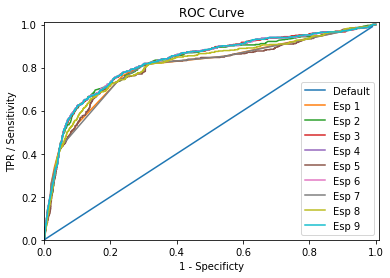

In [65]:
# Construccion de Curva ROC para el conjunto de especificaciones

# False Positive Rate, True Positive Rates y Thresholds

fpr_lr_dft, tpr_lr_dft, thr_lr_dft = roc_curve(y_test, y_pred_proba_lr_dft[:,1])
fpr_lr_esp1, tpr_lr_esp1, thr_lr_esp1 = roc_curve(y_test, y_pred_proba_lr_esp1[:,1])
fpr_lr_esp2, tpr_lr_esp2, thr_lr_esp2 = roc_curve(y_test, y_pred_proba_lr_esp2[:,1])
fpr_lr_esp3, tpr_lr_esp3, thr_lr_esp3 = roc_curve(y_test, y_pred_proba_lr_esp3[:,1])
fpr_lr_esp4, tpr_lr_esp4, thr_lr_esp4 = roc_curve(y_test, y_pred_proba_lr_esp4[:,1])
fpr_lr_esp5, tpr_lr_esp5, thr_lr_esp5 = roc_curve(y_test, y_pred_proba_lr_esp5[:,1])
fpr_lr_esp6, tpr_lr_esp6, thr_lr_esp6 = roc_curve(y_test, y_pred_proba_lr_esp6[:,1])
fpr_lr_esp7, tpr_lr_esp7, thr_lr_esp7 = roc_curve(y_test, y_pred_proba_lr_esp7[:,1])
fpr_lr_esp8, tpr_lr_esp8, thr_lr_esp8 = roc_curve(y_test, y_pred_proba_lr_esp8[:,1])
fpr_lr_esp9, tpr_lr_esp9, thr_lr_esp9 = roc_curve(y_test, y_pred_proba_lr_esp9[:,1])

# Grafico

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(fpr_lr_dft, tpr_lr_dft)
plt.plot(fpr_lr_esp1, tpr_lr_esp1)
plt.plot(fpr_lr_esp2, tpr_lr_esp2)
plt.plot(fpr_lr_esp3, tpr_lr_esp3)
plt.plot(fpr_lr_esp4, tpr_lr_esp4)
plt.plot(fpr_lr_esp5, tpr_lr_esp5)
plt.plot(fpr_lr_esp6, tpr_lr_esp6)
plt.plot(fpr_lr_esp7, tpr_lr_esp7)
plt.plot(fpr_lr_esp8, tpr_lr_esp8)
plt.plot(fpr_lr_esp9, tpr_lr_esp9)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend(['Default','Esp 1', 'Esp 2', 'Esp 3', 'Esp 4', 'Esp 5', 'Esp 6', 'Esp 7', 'Esp 8', 'Esp 9'])
plt.show() 

### Área bajo la Curva ROC

In [66]:
# Calculo de areas bajo la curva: AUC

print(f'El área bajo la curva ROC para la especificación default es: {auc(fpr_lr_dft, tpr_lr_dft).round(5)}\n')
print(f'El área bajo la curva ROC para la especificación 1 es: {auc(fpr_lr_esp1, tpr_lr_esp1).round(5)}\n')
print(f'El área bajo la curva ROC para la especificación 2 es: {auc(fpr_lr_esp2, tpr_lr_esp2).round(5)}\n')
print(f'El área bajo la curva ROC para la especificación 3 es: {auc(fpr_lr_esp3, tpr_lr_esp3).round(5)}\n')
print(f'El área bajo la curva ROC para la especificación 4 es: {auc(fpr_lr_esp4, tpr_lr_esp4).round(5)}\n')
print(f'El área bajo la curva ROC para la especificación 5 es: {auc(fpr_lr_esp5, tpr_lr_esp5).round(5)}\n')
print(f'El área bajo la curva ROC para la especificación 6 es: {auc(fpr_lr_esp6, tpr_lr_esp6).round(5)}\n')
print(f'El área bajo la curva ROC para la especificación 7 es: {auc(fpr_lr_esp7, tpr_lr_esp7).round(5)}\n')
print(f'El área bajo la curva ROC para la especificación 8 es: {auc(fpr_lr_esp8, tpr_lr_esp8).round(5)}\n')
print(f'El área bajo la curva ROC para la especificación 9 es: {auc(fpr_lr_esp9, tpr_lr_esp9).round(5)}')

El área bajo la curva ROC para la especificación default es: 0.82821

El área bajo la curva ROC para la especificación 1 es: 0.80183

El área bajo la curva ROC para la especificación 2 es: 0.82238

El área bajo la curva ROC para la especificación 3 es: 0.82771

El área bajo la curva ROC para la especificación 4 es: 0.82824

El área bajo la curva ROC para la especificación 5 es: 0.79931

El área bajo la curva ROC para la especificación 6 es: 0.82818

El área bajo la curva ROC para la especificación 7 es: 0.7994

El área bajo la curva ROC para la especificación 8 es: 0.80993

El área bajo la curva ROC para la especificación 9 es: 0.82799


### Curva PR

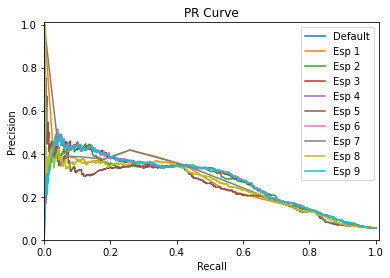

In [67]:
# Construccion de Curva PR para el conjunto de especificaciones

# Precision, Recall y Thresholds

from sklearn.metrics import precision_recall_curve, average_precision_score

precision_dft, recall_dft, thresholds_dft = precision_recall_curve(y_test, y_pred_proba_lr_dft[:,1])
precision_esp1, recall_esp1, thresholds_esp1 = precision_recall_curve(y_test, y_pred_proba_lr_esp1[:,1])
precision_esp2, recall_esp2, thresholds_esp2 = precision_recall_curve(y_test, y_pred_proba_lr_esp2[:,1])
precision_esp3, recall_esp3, thresholds_esp3 = precision_recall_curve(y_test, y_pred_proba_lr_esp3[:,1])
precision_esp4, recall_esp4, thresholds_esp4 = precision_recall_curve(y_test, y_pred_proba_lr_esp4[:,1])
precision_esp5, recall_esp5, thresholds_esp5 = precision_recall_curve(y_test, y_pred_proba_lr_esp5[:,1])
precision_esp6, recall_esp6, thresholds_esp6 = precision_recall_curve(y_test, y_pred_proba_lr_esp6[:,1])
precision_esp7, recall_esp7, thresholds_esp7 = precision_recall_curve(y_test, y_pred_proba_lr_esp7[:,1])
precision_esp8, recall_esp8, thresholds_esp8 = precision_recall_curve(y_test, y_pred_proba_lr_esp8[:,1])
precision_esp9, recall_esp9, thresholds_esp9 = precision_recall_curve(y_test, y_pred_proba_lr_esp9[:,1])

# Grafico

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.plot(recall_dft, precision_dft)
plt.plot(recall_esp1, precision_esp1)
plt.plot(recall_esp2, precision_esp2)
plt.plot(recall_esp3, precision_esp3)
plt.plot(recall_esp4, precision_esp4)
plt.plot(recall_esp5, precision_esp5)
plt.plot(recall_esp6, precision_esp6)
plt.plot(recall_esp7, precision_esp7)
plt.plot(recall_esp8, precision_esp8)
plt.plot(recall_esp9, precision_esp9)
plt.legend(['Default','Esp 1', 'Esp 2', 'Esp 3', 'Esp 4', 'Esp 5', 'Esp 6', 'Esp 7', 'Esp 8', 'Esp 9'])
plt.show() 

### Precision Score Promedio

In [68]:
print(f'La precisión promedio del modelo default es: {average_precision_score(y_test, y_pred_proba_lr_dft[:,1]).round(3)}\n')
print(f'La precisión promedio de la especificación 1 es: {average_precision_score(y_test, y_pred_proba_lr_esp1[:,1]).round(3)}\n')
print(f'La precisión promedio de la especificación 2 es: {average_precision_score(y_test, y_pred_proba_lr_esp2[:,1]).round(3)}\n')
print(f'La precisión promedio de la especificación 3 es: {average_precision_score(y_test, y_pred_proba_lr_esp3[:,1]).round(3)}\n')
print(f'La precisión promedio de la especificación 4 es: {average_precision_score(y_test, y_pred_proba_lr_esp4[:,1]).round(3)}\n')
print(f'La precisión promedio de la especificación 5 es: {average_precision_score(y_test, y_pred_proba_lr_esp5[:,1]).round(3)}\n')
print(f'La precisión promedio de la especificación 6 es: {average_precision_score(y_test, y_pred_proba_lr_esp6[:,1]).round(3)}\n')
print(f'La precisión promedio de la especificación 7 es: {average_precision_score(y_test, y_pred_proba_lr_esp7[:,1]).round(3)}\n')
print(f'La precisión promedio de la especificación 8 es: {average_precision_score(y_test, y_pred_proba_lr_esp8[:,1]).round(3)}\n')
print(f'La precisión promedio de la especificación 9 es: {average_precision_score(y_test, y_pred_proba_lr_esp9[:,1]).round(3)}\n')

La precisión promedio del modelo default es: 0.278

La precisión promedio de la especificación 1 es: 0.243

La precisión promedio de la especificación 2 es: 0.268

La precisión promedio de la especificación 3 es: 0.276

La precisión promedio de la especificación 4 es: 0.278

La precisión promedio de la especificación 5 es: 0.245

La precisión promedio de la especificación 6 es: 0.278

La precisión promedio de la especificación 7 es: 0.229

La precisión promedio de la especificación 8 es: 0.257

La precisión promedio de la especificación 9 es: 0.277



## Conclusiones

- El objetivo de la notebook es construir modelos capaces de predecir la institución de un plazo fijo por parte de los clientes de un banco comercial que son contactados en el contexto de una campaña de marketing, a partir de características del cliente, de la campaña de marketing y del contexto macroeconómico en el que se da el contacto.
- El modelo que presenta esta notebook es el Logístico.
- Como las clases de la variable target están desbalanceadas, balanceamos el dataset. Además, como el desbalanceo implica que la target original toma el valor 1 apenas en el 5% de las observaciones, nuestro análisis considera a *recall*, *precision* y *f1 score* como las medidas de evaluación más adecuadas para el contexto.
- A la vez, consideramos 4 conjuntos de hiperparámetros distintos: el conjunto default y 3 más construidos a partir de la información dada por la documentación del algoritmo. Así, la notebook presenta resultados para 10 especificaciones distintas de Logistic Regression.
- En general, las distintas especificaciones muestran valores similares de cada uno de los scores de evaluación. Si bien obtenemos valores altos para *recall* (aprox.75%), no es tal el caso de *precision* (aprox.16%), lo cual implica también valores bajos para el *f1 score* (aprox.26%).
- Esto se puede leer como que el algoritmo, al mismo tiempo que logra captar relativamente bien al cliente que potencialmente va a tomar el plazo fijo (*recall*), sobreestima el tamaño de la población potencial de dichos clientes (*precision*). Si el banco toma este algoritmo, va a captar a muchos clientes correctamente, pero a un costo alto de campaña de marketing.


## Guardamos en pickle

Guardamos en pickle la instancia del mejor modelo entrenado. Consideraremos al como mejor modelo a aquel en el que se maximizo el *f1 score*.


In [69]:
# Vemos cual es el modelo que tuvo el mejor f1 score

f1_scores = np.array([scores_dft[7], scores_esp1[7], scores_esp2[7], scores_esp3[7], scores_esp4[7], scores_esp5[7], 
             scores_esp6[7], scores_esp7[7], scores_esp8[7], scores_esp9[7]])

f1_scores_max = np.max(f1_scores)

np.where(f1_scores == f1_scores_max)

(array([2, 5], dtype=int64),)

Vemos que las especificaciones 2 y 5 tuvieron el mismo f1 score. Tomamos la 5 porque es la que surge de optimizar hiperparámetros con la mayor cantidad de solvers a disposición.

In [70]:
import pickle

lr_best = open("lr_best", 'wb')
pickle.dump(model_lr_esp5, lr_best) # Guardar el modelo
